## Part 0: Setting things up -- libraries and functions

### Loading needed libraries

In [432]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Plotting functions

In [2]:
### Plotting the results
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize)/kernelSize, 'valid')
    return array

def plot_dqn(obj, title = 'DQN'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(311)
    plt.plot(convolve(obj.loss_vec, kernelSize=11)/11)
    plt.title(title+' loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(312)
    plt.plot(convolve(obj.loss_vec, kernelSize=111)/111)
    plt.title(title+' smoothed loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(313)
    plt.plot(np.array(obj.returns)[:,0],np.array(obj.returns)[:,1])
    plt.xlabel('timesteps'), plt.ylabel('return')
    plt.title(title+' training performance')
    plt.show()

def plot_dsr(obj, title='DSR'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(211)
    plt.plot(convolve(obj.loss_q_vec, kernelSize=111))
    plt.title(title+' loss')
    plt.ylabel('loss q value'), plt.xlabel('batch no')
    plt.subplot(212)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=111))
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def plot_dsr2(obj, title='DSR'):
    plt.figure(figsize=(12,4),dpi=100)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def params_count(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

### Sanity check functions

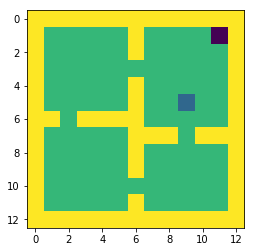

In [132]:
plt.imshow(env.render())

In [3]:
from deep_rl.component.fourrooms import FourRooms
env = FourRooms(goal=9)

def _visualize_vector(vector, title="unnamed", show_goal=False, show=True, label=None):
    """Function to visualize vector of size 104"""
    
    current_grid = np.array(env.occupancy, dtype=np.float) # 1 - walls, 0 - 
    for i in range(104):
    #     if(vals[i]>0):
    #         import pdb; pdb.set_trace()
        p_cell = env.tocell[i]
        current_grid[p_cell[0], p_cell[1]] = vector[i]

        if show_goal:
            goal_cell = env.tocell[env.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -1
        
    plt.imshow(current_grid), plt.colorbar()
    plt.title(title)
    if show:
        plt.show()
        
def sanity(agent, is_dsr=True, title="unnamed"):
    
    print(agent.network)
    plt.figure(figsize=(10,10))
    
    # Setting things up
    env = FourRooms(goal=9)
    
    # Visualize w
    if(is_dsr):
        plt.subplot(221)
        w_vector = agent.network.state_dict()['psi2q.w'].numpy()
        _visualize_vector(w_vector, title=title+" w learnt values", show=False)
    
    # Visualize psi
    if(is_dsr):
        plt.subplot(222)
        states = [100]
#         plt.figure(figsize=(len(states)*12, 5))

        for i, s in enumerate(states):
            temp = np.zeros(104)
            temp[s] = 1
            phi, psi, q = agent.network(tensor(temp).unsqueeze(0))
            psi = psi.detach().numpy()
            optimal_actions = q.max(1)[1].detach().numpy()
            psi = psi[:, optimal_actions, :]
            q = q.detach().numpy().flatten()
#             _visualize_vector(psi[:,0,:].flatten(), title=title+" q({},{})={}".format(s, 0, q[0]), show=False, label="0")
            _visualize_vector(psi.flatten(), title=title+" psi*, s = {}".format(s), show=False, label="1")
            
    # Visualize policy
    state_space = np.identity(104)
    if(is_dsr):
        
        phi, psi, q = agent.network(tensor(state_space))
    else:
        q = agent.network(tensor(state_space))
    
    plt.subplot(223)
    optimal_actions = q.max(1)[1].detach().numpy()
    _visualize_vector(optimal_actions, title=title+'policy (0:up,1:down,2:left,3:right)', show=False)
    plt.subplot(224)
    _visualize_vector(q.max(1)[0].detach().numpy(), title=title+' Q* estimates')
    
    return
  
def sanity_psi(dsr, action_net=None, states=[0, 100, 10, 97], title="unnamed"):
    """
    action_net needs to be a DQN or None for this funciton to work.
    """
    plt.figure(figsize=(10,10))
    state_space = np.identity(104)
    phi, psi, q = dsr.network(tensor(state_space))
    psi = psi.detach().numpy()
    if(action_net is not None):
        q = action_net.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    
    psi = psi[:, optimal_actions, :]

    for i, s in enumerate(states):
        plt.subplot(2,2,i+1)
        _visualize_vector(psi[s,:,:,].flatten(), title=title+" psi*, s = {}".format(s), show=False, label="1")
    return

sanity_psi(avdsr)
# sanity(avdsr, is_dsr=False, title='initDSR, f2')
# plot_dqn(dqn, title='initDSR, f2')
# dsr1 = dsr2
# print(dsr1.loss_psi_vec[:10],dsr1.loss_q_vec[:10])
# print(dsr1.loss_psi_vec[-10:],dsr1.loss_q_vec[-10:])

NameError: name 'avdsr' is not defined

(104, 2)


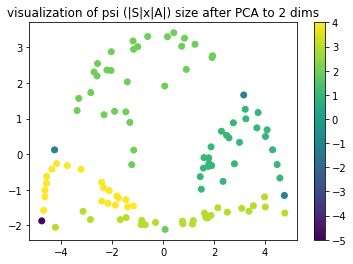

In [22]:
from sklearn.decomposition import PCA

def dimenRed(vis_agent):
    """
    Function to reduce the dimensionality of the psi(s,a) representations learnt,
    and visualizing them.
    """
    state_space = np.identity(104)
    c = np.ones(104)*4
    room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
    room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
    room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
    connect = [25, 51, 62, 88]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -1, -1, -1]
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    psi = psi.view(104,-1).detach().numpy()
    pca = PCA(n_components=2)
    k = pca.fit_transform(psi)
    print(k.shape)
    plt.scatter(k[:,0],k[:,1],c=c)
    plt.colorbar()
    plt.title('visualization of psi (|S|x|A|) size after PCA to 2 dims')
    
    
def dimenRed2(vis_agent, act_agent):
    """
    Function to reduce the dimensionality of the psi* representations learnt,
    and visualizing them.
    NOTE: psi*, where are the optimal actions picked from matters. act_agent 
    is used here.
    """
    state_space = np.identity(104)
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    
    if('DSR' in str(type(act_agent))):
        _, _, q = act_agent.network(tensor(state_space))
    else:
        q = act_agent.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    
    pass

dimenRed(avdsr)

### DSR training function

In [4]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1
#     config.freeze = False

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=())
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    # Train an agent with the above config
    agent = DSRAgent(config)
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

### DQN training function

In [5]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
    return agent

## Part 1: Run basic DSR and DQN to confirm they learn the task

In [6]:
class Psi2QNetFC(nn.Module):
    def __init__(self, output_dim, feature_dim, hidden_units=(), gate=F.relu):
        super(Psi2QNetFC, self).__init__()

        dims = (feature_dim*output_dim,) + hidden_units + (output_dim,)
        self.layers = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.gate = gate
    
    def forward(self, psi):
        out = psi.view(psi.size(0), -1)
        for layer in self.layers[:-1]:
            out = self.gate(layer(out))
        out = self.layers[-1](out)
        return out

class SRNet(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(), gate=F.relu):
        super(SRNet, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        dims = (body.feature_dim,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.psi2q = Psi2QNetFC(output_dim, body.feature_dim)

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = self.psi2q(psi)

        return phi, psi, out

In [6]:
# dsr1 = dsr_feature(game='FourRooms-Goal-9', freeze=0)
# dsr2 = dsr_feature(game='FourRooms-Goal-9', freeze=1)
dqn = dqn_feature(game='FourRooms-Goal-9')

2020-04-29 19:10:04,411 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-29 19:10:09,214 - root - INFO: steps 5000, episodic_return_test -180.40(18.59)
2020-04-29 19:10:13,676 - root - INFO: steps 10000, episodic_return_test -122.00(30.21)
2020-04-29 19:10:17,884 - root - INFO: steps 15000, episodic_return_test -45.10(24.51)
2020-04-29 19:10:22,076 - root - INFO: steps 20000, episodic_return_test -27.60(18.20)
2020-04-29 19:10:26,195 - root - INFO: steps 25000, episodic_return_test -28.80(18.06)
2020-04-29 19:10:30,435 - root - INFO: steps 30000, episodic_return_test -65.90(27.78)
2020-04-29 19:10:34,888 - root - INFO: steps 35000, episodic_return_test -28.20(18.16)
2020-04-29 19:10:39,661 - root - INFO: steps 40000, episodic_return_test -11.10(1.22)
2020-04-29 19:10:44,233 - root - INFO: steps 45000, episodic_return_test -9.50(1.67)
2020-04-29 19:10:48,879 - root - INFO: steps 50000, episodic_return_test -9.70(1.54)
Process AsyncReplay-1:
Traceback (most recent call 

In [81]:
print(dqn.network.body)

FCBody(
  (layers): ModuleList(
    (0): Linear(in_features=104, out_features=16, bias=True)
  )
)


In [119]:
45348-1668

43680

In [120]:
params_count(dqn.network), params_count(initdsr1.network)

(45348, 45348)

Text(0.5,1,'DQN l')

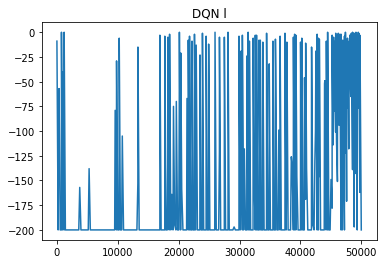

In [104]:
plt.plot(np.array(dqn.returns)[:,0],np.array(dqn.returns)[:,1])
plt.title('DQN l')

## Part 2: Train an avSR initialization 

In [7]:
def runNAgents(function, runs, store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRooms-Goal-9', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [ ]:
agents, _, _ = runNAgents(dqn_feature, runs=1, store=True)

In [8]:
def avdsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=()) #CHECK
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e6), batch_size=10)

    config.random_action_prob = LinearSchedule(0.2, 0.2, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [8]:
avdsr = avdsr_feature(game='FourRooms-Goal-9', agents=[dqn])

2020-04-29 19:10:49,342 - root - INFO: steps 0, 97541953.49 steps/s
2020-04-29 19:10:50,653 - root - INFO: steps 1000, 764.08 steps/s
2020-04-29 19:10:51,881 - root - INFO: steps 2000, 815.58 steps/s
2020-04-29 19:10:53,169 - root - INFO: steps 3000, 776.64 steps/s
2020-04-29 19:10:54,430 - root - INFO: steps 4000, 794.49 steps/s
2020-04-29 19:10:56,088 - root - INFO: steps 5000, 603.67 steps/s
2020-04-29 19:10:57,497 - root - INFO: steps 6000, 711.04 steps/s
2020-04-29 19:10:58,821 - root - INFO: steps 7000, 756.45 steps/s
2020-04-29 19:11:00,294 - root - INFO: steps 8000, 679.37 steps/s
2020-04-29 19:11:01,542 - root - INFO: steps 9000, 802.11 steps/s
2020-04-29 19:11:02,920 - root - INFO: steps 10000, 726.17 steps/s
2020-04-29 19:11:04,117 - root - INFO: steps 11000, 836.31 steps/s
2020-04-29 19:11:05,552 - root - INFO: steps 12000, 697.62 steps/s
2020-04-29 19:11:07,250 - root - INFO: steps 13000, 589.39 steps/s
2020-04-29 19:11:08,721 - root - INFO: steps 14000, 680.15 steps/s
202

Text(0.5,1,'unsupervised learning loss does go down')

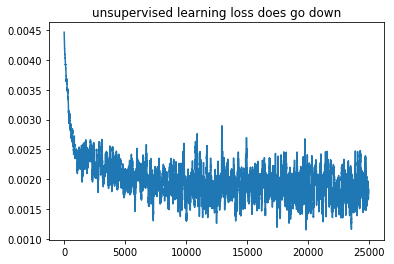

In [9]:
plt.plot(convolve(avdsr.loss_vec, 50))
plt.title('unsupervised learning loss does go down')

In [9]:
sanity(avdsr)

NameError: name 'sanity' is not defined

## Part 3: Train N agents of all styles on same environment and compare results

### SR with FC layer projections to estimate value

In [9]:
class SRNet(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(), gate=F.relu):
        super(SRNet, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        dims = (body.feature_dim,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.psi2q = Psi2QNetFC(output_dim, body.feature_dim)

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = self.psi2q(psi)

        return phi, psi, out

In [53]:
def layer_uniform(layer):
    nn.init.uniform_(layer.weight.data)
    nn.init.uniform_(layer.bias.data)
    return layer

In [54]:
class SRNet(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(), gate=F.relu):
        super(SRNet, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        dims = (body.feature_dim,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_uniform(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.psi2q = Psi2QNet(output_dim, body.feature_dim)

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = self.psi2q(psi)

        return phi, psi, out

In [44]:
env = FourRooms()
state = env.reset()

In [55]:
# r_avdsr = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr)
r_avdsr = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=None, store=True)

runs:   0%|          | 0/1 [00:00<?, ?it/s]2020-04-29 20:16:20,551 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-29 20:16:25,731 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-04-29 20:16:30,728 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-04-29 20:16:35,907 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-04-29 20:16:41,228 - root - INFO: steps 20000, episodic_return_test -200.00(0.00)
2020-04-29 20:16:46,366 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-04-29 20:16:52,028 - root - INFO: steps 30000, episodic_return_test -200.00(0.00)
2020-04-29 20:16:58,232 - root - INFO: steps 35000, episodic_return_test -200.00(0.00)
2020-04-29 20:17:04,035 - root - INFO: steps 40000, episodic_return_test -200.00(0.00)
2020-04-29 20:17:09,433 - root - INFO: steps 45000, episodic_return_test -200.00(0.00)
2020-04-29 20:17:15,090 - root - INFO: steps 50000, episodic_return_test -200.00(0.00)
runs:

In [22]:
# r_dsr1 = runNAgents(dsr_feature, 10, freeze=0)
# r_dsr2 = runNAgents(dsr_feature, 10, freeze=1)
# r_dqn = runNAgents(dqn_feature, 10)
# r_avdsr1 = runNAgents(dsr_feature_init, 1, freeze=1, ref=avdsr)
# r_avdsr = runNAgents(dsr_feature_init, 10, freeze=1, ref=avdsr)
r_avdsr = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr)

runs:   0%|          | 0/5 [00:00<?, ?it/s]2020-04-24 13:41:51,479 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-24 13:41:57,392 - root - INFO: steps 5000, episodic_return_test -180.60(18.40)
2020-04-24 13:42:02,739 - root - INFO: steps 10000, episodic_return_test -8.10(1.34)
2020-04-24 13:42:08,282 - root - INFO: steps 15000, episodic_return_test -10.60(1.69)
2020-04-24 13:42:13,978 - root - INFO: steps 20000, episodic_return_test -10.00(1.75)
2020-04-24 13:42:21,069 - root - INFO: steps 25000, episodic_return_test -12.20(1.27)
2020-04-24 13:42:27,907 - root - INFO: steps 30000, episodic_return_test -25.60(18.40)
2020-04-24 13:42:34,341 - root - INFO: steps 35000, episodic_return_test -6.50(1.44)
2020-04-24 13:42:40,771 - root - INFO: steps 40000, episodic_return_test -46.40(24.34)
2020-04-24 13:42:47,150 - root - INFO: steps 45000, episodic_return_test -10.80(1.91)
2020-04-24 13:42:53,663 - root - INFO: steps 50000, episodic_return_test -7.60(1.32)
runs:  20%|██ 

  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [20]:
initdsr2 = dsr_feature_init(game='FourRooms-Goal-9', ref=avdsr, freeze=2)

2020-04-24 13:39:34,130 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-24 13:39:39,928 - root - INFO: steps 5000, episodic_return_test -122.30(30.10)
2020-04-24 13:39:45,406 - root - INFO: steps 10000, episodic_return_test -26.50(18.35)
2020-04-24 13:39:51,124 - root - INFO: steps 15000, episodic_return_test -66.30(27.71)
2020-04-24 13:39:57,203 - root - INFO: steps 20000, episodic_return_test -46.50(24.31)
2020-04-24 13:40:03,624 - root - INFO: steps 25000, episodic_return_test -7.50(1.58)
2020-04-24 13:40:10,279 - root - INFO: steps 30000, episodic_return_test -9.60(1.10)
2020-04-24 13:40:19,826 - root - INFO: steps 35000, episodic_return_test -25.60(18.40)
2020-04-24 13:40:28,325 - root - INFO: steps 40000, episodic_return_test -7.20(1.42)
2020-04-24 13:40:36,111 - root - INFO: steps 45000, episodic_return_test -9.40(1.84)
2020-04-24 13:40:43,761 - root - INFO: steps 50000, episodic_return_test -7.80(1.99)
Process AsyncReplay-11:
Traceback (most recent call last)

In [17]:
initdsr1 = dsr_feature_init(game='FourRooms-Goal-9', ref=avdsr, freeze=1)

2020-04-24 13:38:07,316 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-24 13:38:15,482 - root - INFO: steps 5000, episodic_return_test -83.30(30.14)
2020-04-24 13:38:23,153 - root - INFO: steps 10000, episodic_return_test -102.00(30.99)
Process AsyncReplay-7:
Traceback (most recent call last):
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/mnt/c/Users/Surya Penmetsa/Desktop/McGill Courses/Thesis/code/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
sanity(initdsr1)
plot_dqn(initdsr1)

In [430]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [ ]:
last1 = runNAgents(dsr_feature_init, 1, freeze=True, ref=agent)

In [125]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6))
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = np.interp(np.arange(clip), t, r)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(), plt.show()

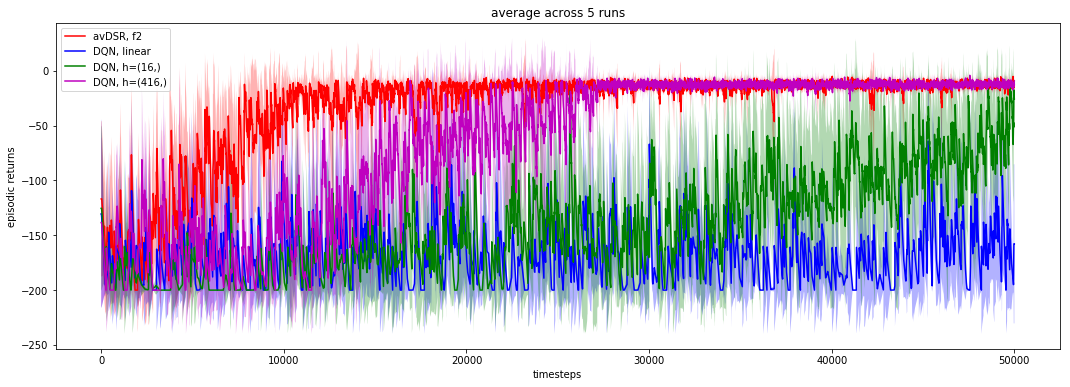

In [295]:
rewards_dict = {'avDSR, f2': r_avdsr, 'DQN, linear': r_dqn, 'DQN, h=(16,)': r_dqn2, 'DQN, h=(416,)': r_dqn3}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='average across 5 runs')

## Transfer experiments
1. Train DQN on 3 random tasks
2. Learn avDSR init by taking actions from DQN
3. Train avDSR (freeze=2) 

(another idea on 2 -- instead of picking an agent each timestep, pick an agent each episode -- this makes more sense for me intuitively)

[37 12 72  9]


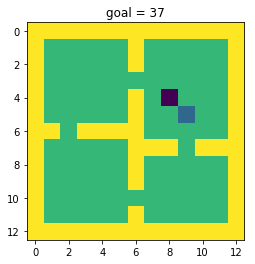

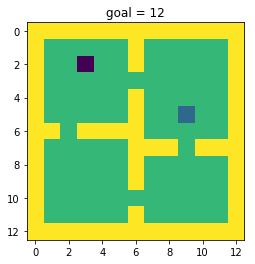

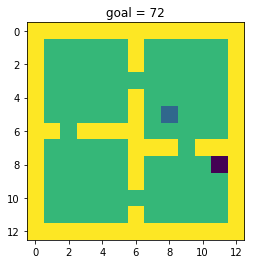

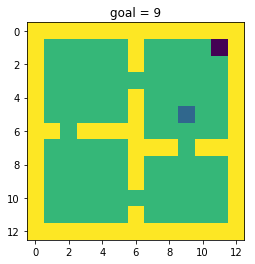

In [10]:
np.random.seed(1)
goal_locs = np.random.choice(104, 4)
goal_locs[3] = 9
print(goal_locs)
for i in range(4):
    env = FourRooms(goal=goal_locs[i])
    env.reset()
    plt.imshow(env.render())
    plt.title('goal = ' + str(goal_locs[i]))
    plt.show()

In [11]:
dqn1 = dqn_feature(game='FourRooms-Goal-'+str(goal_locs[0]))
dqn2 = dqn_feature(game='FourRooms-Goal-'+str(goal_locs[1]))
dqn3 = dqn_feature(game='FourRooms-Goal-'+str(goal_locs[2]))

2020-04-29 21:52:42,564 - root - INFO: steps 0, episodic_return_test -180.10(18.88)
2020-04-29 21:52:48,659 - root - INFO: steps 5000, episodic_return_test -81.60(30.57)
2020-04-29 21:52:57,222 - root - INFO: steps 10000, episodic_return_test -121.40(30.44)
2020-04-29 21:53:03,055 - root - INFO: steps 15000, episodic_return_test -43.80(24.70)
2020-04-29 21:53:08,036 - root - INFO: steps 20000, episodic_return_test -5.80(0.73)
2020-04-29 21:53:14,422 - root - INFO: steps 25000, episodic_return_test -6.80(1.40)
2020-04-29 21:53:24,798 - root - INFO: steps 30000, episodic_return_test -6.40(0.97)
2020-04-29 21:53:32,743 - root - INFO: steps 35000, episodic_return_test -5.40(1.03)
2020-04-29 21:53:39,861 - root - INFO: steps 40000, episodic_return_test -6.70(1.08)
2020-04-29 21:53:47,462 - root - INFO: steps 45000, episodic_return_test -9.30(0.86)
2020-04-29 21:53:58,818 - root - INFO: steps 50000, episodic_return_test -5.60(1.34)
2020-04-29 21:53:59,840 - root - INFO: steps 0, episodic_ret

In [12]:
# Printing network to ensure we're training the correct one
print(dqn1.network)
print(params_count(dqn1.network))

VanillaNet(
  (fc_head): Linear(in_features=416, out_features=4, bias=True)
  (body): FCBody(
    (layers): ModuleList(
      (0): Linear(in_features=104, out_features=416, bias=True)
    )
  )
)
45348


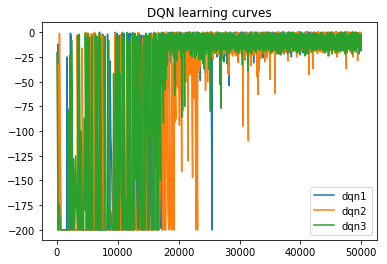

In [370]:
# Plot DQN learning curves to ensure learning
plt.plot(np.array(dqn1.returns)[:,0],np.array(dqn1.returns)[:,1], label='dqn1')
plt.plot(np.array(dqn2.returns)[:,0],np.array(dqn2.returns)[:,1], label='dqn2')
plt.plot(np.array(dqn3.returns)[:,0],np.array(dqn3.returns)[:,1], label='dqn3')
plt.title('DQN learning curves'), plt.legend()
plt.show()

VanillaNet(
  (fc_head): Linear(in_features=416, out_features=4, bias=True)
  (body): FCBody(
    (layers): ModuleList(
      (0): Linear(in_features=104, out_features=416, bias=True)
    )
  )
)


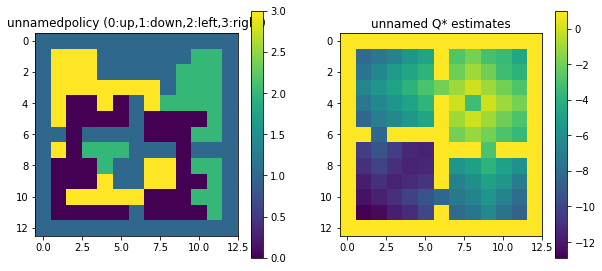

In [371]:
sanity(dqn1, is_dsr=False)

In [414]:
import random
"""
Code for learning the averageSR agent across good policies.
"""

class avDSRActor(BaseActor):
    def __init__(self, config, agents, style='DQN'):
        BaseActor.__init__(self, config)
        self.config = config
        self.agents = agents
        self.style = style

        # Parameters to decide which agents should learn
        self.batch_steps = 0
        self.switch_period = 10
        self.agent_id = 0

        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        
        self.batch_steps += 1
        if(self.batch_steps % self.switch_period == 0): 
            # CHECK: multiprocessing might be screwing something up
            self.agent_id = np.random.randint(len(self.agents))
        pick = self.agents[self.agent_id]

        # Find qvalues of the picked agent for the present state
        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick.network(config.state_normalizer(self._state))
            elif(self.style == 'DQN'):
                q_values = pick.network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()

        # Take action based on this estimated q value
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
            
        next_state, reward, done, info = self._task.step([action])
        
        # Also estimate next action
        #############
        pick2 = pick
        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick2.network(config.state_normalizer(next_state))
            elif(self.style=='DQN'):
                q_values = pick2.network(config.state_normalizer(next_state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            next_action = np.random.randint(0, len(q_values))
        else:
            next_action = np.argmax(q_values)
        
        entry = [self._state[0], action, reward[0], next_state[0], next_action, int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class avDSRAgent(BaseAgent):
    def __init__(self, config, agents, style='DQN'):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.actor = avDSRActor(config, agents, style)

        self.network = config.network_fn()
        self.network.share_memory()
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size) # Need to make this size bigger

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:
#             self.record_online_return(info)
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Getting samples from buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Estimate targets
            with torch.no_grad():
                _, psi_next, _ = self.network(next_states)

            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            phi, psi, _ = self.network(states)
            psi_next.add_(phi) # TODO: double chec this

            # Computing estimates
            actions = tensor(actions).long()
            psi = psi[self.batch_indices, actions, :]
            
            
#             loss_psi = (psi_next - psi).pow(2).mul(0.5).mean(0)
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()

            loss = loss_psi
            
            total_loss = loss.mean()
            self.loss_vec.append(total_loss.item())
            self.loss_psi_vec.append(total_loss.item())
            
            
            self.optimizer.zero_grad()
#             loss.backward(torch.ones(loss.shape))
            loss.backward()

            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()

In [421]:
def avdsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.01)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=()) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(0.7, 0.7, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e4
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [422]:
# Learn avDSR agent
avdsr = avdsr_feature(game='FourRooms-Goal-9', agents=[dqn1, dqn2, dqn3])

2020-05-01 17:15:42,412 - root - INFO: steps 0, 182361043.48 steps/s
2020-05-01 17:15:43,585 - root - INFO: steps 1000, 855.22 steps/s
2020-05-01 17:15:44,764 - root - INFO: steps 2000, 849.82 steps/s
2020-05-01 17:15:45,962 - root - INFO: steps 3000, 838.35 steps/s
2020-05-01 17:15:47,210 - root - INFO: steps 4000, 802.42 steps/s
2020-05-01 17:15:48,314 - root - INFO: steps 5000, 907.49 steps/s
2020-05-01 17:15:49,433 - root - INFO: steps 6000, 895.44 steps/s
2020-05-01 17:15:50,542 - root - INFO: steps 7000, 902.92 steps/s
2020-05-01 17:15:51,676 - root - INFO: steps 8000, 884.04 steps/s
2020-05-01 17:15:52,806 - root - INFO: steps 9000, 886.37 steps/s
2020-05-01 17:15:54,001 - root - INFO: steps 10000, 838.70 steps/s


In [423]:
state = np.zeros(10000)
for i in range(10000):
    state[i] = np.argmax(avdsr.replay.data[i][0])
print(state)

[48. 38. 37. ... 23. 22. 23.]


In [424]:
counts = np.zeros(104)
for i in range(10000):
    counts[int(state[i])] += 1

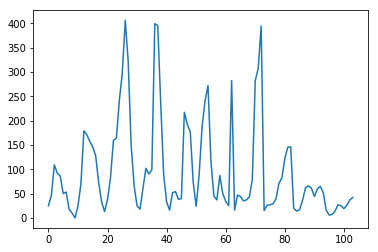

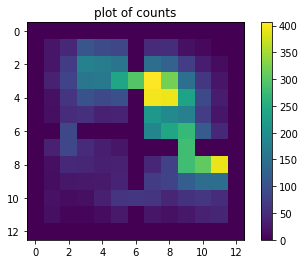

In [425]:
plt.plot(counts), plt.show()
_visualize_vector(counts, title='plot of counts')

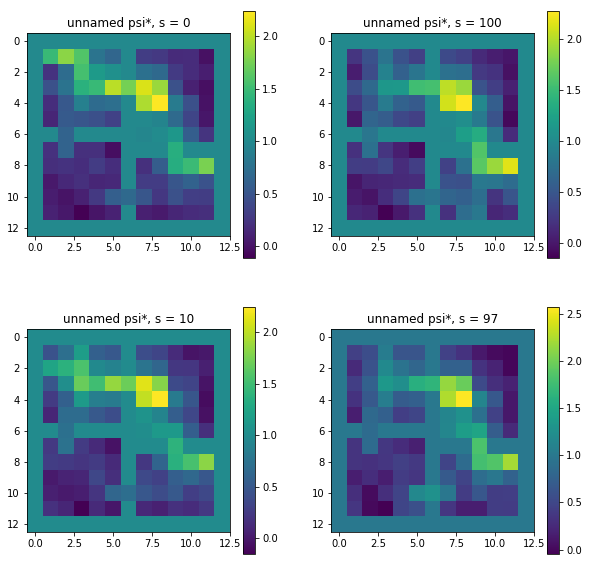

In [426]:
sanity_psi(avdsr)

In [348]:
avdsr.replay.sample() # s, a, r, s2, a2, term

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([2, 3, 0, 2, 0, 2, 2, 3, 0, 3]),
 array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([3, 2, 0, 3, 3, 3, 0, 1, 1, 2]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [349]:
# train a linear network to minimize loss aon this linear network and see if it works
class LinearNet(nn.Module):
    def __init__(self, in_size=104, out_size=416,hidden_units=()):
        super(LinearNet, self).__init__()
        self.gate = F.relu
        dims = (in_size,) + hidden_units + (out_size,)
        self.layers = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])

    def forward(self, x):
        y = tensor(x)
        for layer in self.layers[:-1]:
            y = self.gate(layer(y))
        y = self.layers[-1](y)
        y = y.view(y.size(0), 4, -1)
        return y

In [230]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt

In [350]:
avdsr.replay.sample()

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([3, 2, 2, 2, 3, 2, 3, 1, 1, 1]),
 array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([1, 2, 2, 3, 1, 0, 1, 0, 3, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [232]:
state = env.reset()

In [233]:
np.argmax(state==1)

25

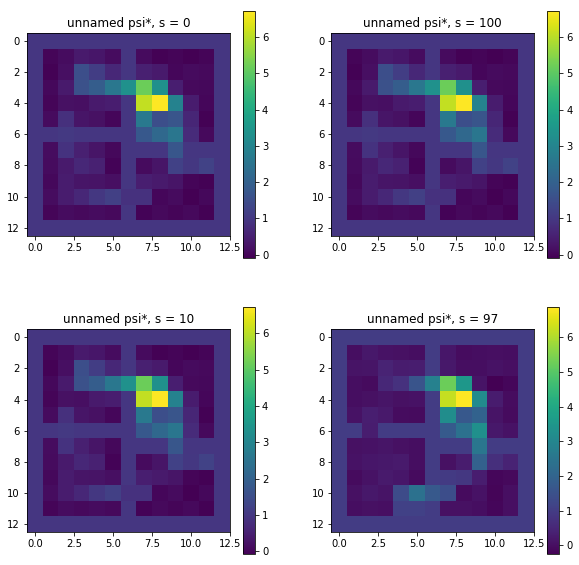

In [357]:
def sanity_psi2(model, action_net=None, states=[0, 100, 10, 97], title="unnamed"):
    """
    action_net needs to be a DQN or None for this funciton to work.
    """
    plt.figure(figsize=(10,10))
    state_space = np.identity(104)
    psi = model(tensor(state_space))
    psi = psi.detach().numpy()
    if(action_net is not None):
        q = action_net.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    
    psi = psi[:, optimal_actions, :]

    for i, s in enumerate(states):
        plt.subplot(2,2,i+1)
        _visualize_vector(psi[s,:,:,].flatten(), title=title+" psi*, s = {}".format(s), show=False, label="1")
    return

def sanity_q(model, title="unnamed"):
    state_space = np.identity(104)
    q = model(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    q = q.detach().numpy()
    q = q[:, optimal_actions]
    _visualize_vector(q.flatten(), title=title, show=True, label="1")

sanity_psi2(model, action_net = dqn1)

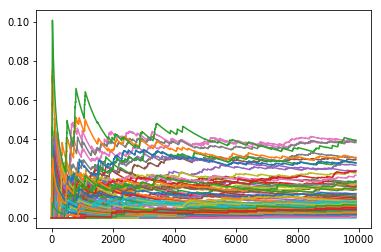

In [429]:
for i in range(104):
    plt.plot(np.divide(np.cumsum(state[100:]==i),np.arange(100,10000)), label=i)
# plt.legend(), plt.show()

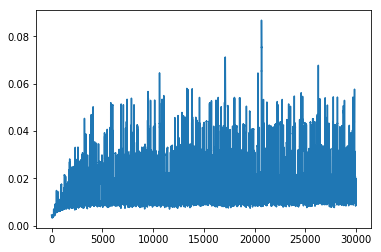

([<matplotlib.lines.Line2D at 0x7fdd63bbac88>], None)

In [356]:
model = LinearNet(hidden_units=())
q_model = LinearNet(out_size=4)
# t_model = LinearNet()
# t_model.load_state_dict(model.state_dict())
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
# optimizer2 = torch.optim.SGD(q_model.parameters(), lr=3e-2)
loss_vec, loss_vec2 = [], []

batch_indices = range_tensor(avdsr.replay.batch_size)
freq=5000

for t in tqdm(range(30000)):
    
    # Get experiences
    experiences = avdsr.replay.sample()
    states, actions, rewards, next_states, next_actions, terminals = experiences
    next_actions = tensor(next_actions).long()
    actions = tensor(actions).long()
    terminals = tensor(terminals)
    rewards = tensor(rewards)
    
    # Estimate targets without gradient calculation
    with torch.no_grad():
        psi_next = model(next_states)
#         q_next = q_model(next_states)
    psi_next = psi_next[batch_indices, next_actions, :]
    psi_next = 0.99 * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
    psi_next.add_(tensor(states))
#     q_next = 0.99 * q_next * (1 - terminals)
#     q_next.add_(rewards)
#     psi_next = tensor(np.random.rand(10,104))

    # Estimate psi    
    psi = model(states)
    psi = psi[batch_indices, actions, :]
#     q = q_model(states)

    # Compute and print loss
    loss = (psi_next - psi).pow(2).mul(0.5).mean()
#     loss2 = (q_next - q).pow(2).mul(0.5).mean()
#     import pdb; pdb.set_trace()
#     print(loss.shape)
    
    loss_vec.append(loss.item())
#     loss_vec2.append(loss2.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     optimizer2.zero_grad()
#     loss2.backward()
#     optimizer2.step()
    
#     if(t % freq == 0):
#         t_model.load_state_dict(model.state_dict())
    
plt.plot(convolve(loss_vec,20)), plt.show()
# plt.plot(convolve(loss_vec2,20)), plt.show()

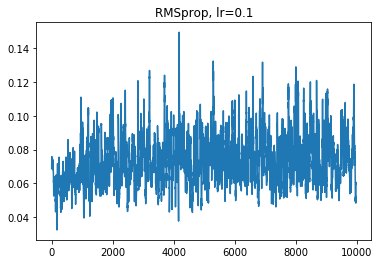

([<matplotlib.lines.Line2D at 0x7fdd67f7fcc0>],
 Text(0.5,1,'RMSprop, lr=0.1'),
 None)

In [354]:
plt.plot(convolve(loss_vec,20)), plt.title('RMSprop, lr=0.1'), plt.show()
# plt.plot(convolve(loss_vec2,200)), plt.show()
# sanity_q(q_model)

In [313]:
# train a linear network to minimize loss aon this linear network and see if it works
class LinearNet(nn.Module):
    def __init__(self, in_size=104, out_size=104,hidden_units=()):
        super(LinearNet, self).__init__()
        self.gate = F.relu
        dims = (in_size,) + hidden_units + (out_size,)
        self.layers = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])

    def forward(self, x):
        y = tensor(x)
        for layer in self.layers[:-1]:
            y = self.gate(layer(y))
        y = self.layers[-1](y)
        return y

model = LinearNet(hidden_units=())
# t_model = LinearNet()
# t_model.load_state_dict(model.state_dict())
optimizer = torch.optim.SGD(model.parameters(), lr=3e-2)
loss_vec = []
batch_indices = range_tensor(avdsr.replay.batch_size)
freq=5000

for t in tqdm(range(50000)):
    
    # Get experiences
    experiences = avdsr.replay.sample()
    states, actions, rewards, next_states, next_actions, terminals = experiences
    next_actions = tensor(next_actions).long()
    actions = tensor(actions).long()
    terminals = tensor(terminals)
    
    # Estimate targets without gradient calculation
    with torch.no_grad():
        psi_next = model(next_states)
    psi_next = 0.99 * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
    psi_next.add_(tensor(states))
    
    # Estimate psi    
    psi = model(states)

    # Compute and print loss
    loss = (psi_next - psi).pow(2).mul(0.5).mean(0)
    
    loss_vec.append(loss.mean().item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward(torch.ones(loss.shape))
    optimizer.step()
    

Text(0.5,1,'trying just psi (104) size')

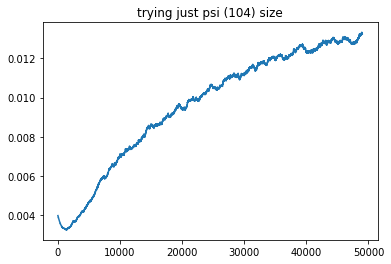

In [315]:
# plot DSR loss to ensure learning
plt.plot(convolve(loss_vec, 1000))
plt.title('trying just psi (104) size')

In [ ]:
sanity_psi(avdsr, states=[0,6,93,103], title='h=(,)')
# sanity_psi(avdsr, action_net=dqn1, states=[0,26,97,103], title='h=(,)')

In [237]:
# Learn agents based on DSR avDSR on the new task
def runNAgents(function, runs, goal=9,store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRooms-Goal-'+str(goal), freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [433]:
r_avdsr_transfer_dqn = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr)

runs:   0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: Error(s) in loading state_dict for SRNet:
	Missing key(s) in state_dict: "psi2q.w". 
	Unexpected key(s) in state_dict: "psi2q.layers.0.weight", "psi2q.layers.0.bias". 

In [308]:
r_avdsr_transfer_eps = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr)




runs:   0%|          | 0/5 [00:00<?, ?it/s]2020-04-25 19:11:17,693 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-25 19:11:23,480 - root - INFO: steps 5000, episodic_return_test -103.20(30.62)
2020-04-25 19:11:29,645 - root - INFO: steps 10000, episodic_return_test -102.90(30.71)
2020-04-25 19:11:34,607 - root - INFO: steps 15000, episodic_return_test -44.30(24.67)
2020-04-25 19:11:39,993 - root - INFO: steps 20000, episodic_return_test -7.10(1.01)
2020-04-25 19:11:47,111 - root - INFO: steps 25000, episodic_return_test -10.00(1.54)
2020-04-25 19:11:56,785 - root - INFO: steps 30000, episodic_return_test -126.30(28.55)
2020-04-25 19:12:06,228 - root - INFO: steps 35000, episodic_return_test -9.20(1.52)
2020-04-25 19:12:15,416 - root - INFO: steps 40000, episodic_return_test -11.50(1.78)
2020-04-25 19:12:24,057 - root - INFO: steps 45000, episodic_return_test -12.30(1.29)
2020-04-25 19:12:33,309 - root - INFO: steps 50000, episodic_return_test -8.00(1.32)



runs:

In [318]:
rewards_dict = {'avDSR, f2 (random init)': r_avdsr_transfer_eps, 'avDSR, f2 (DQNinit-37,12,72)': r_avdsr_transfer_dqn,
                'DQN, linear': r_dqn, 'DQN, h=(16,)': r_dqn2, 'DQN, h=(416,)': r_dqn3}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='average across 5 runs (env: FourRooms9)')
print('NOTE: unspervised exploration has been done on the same environment')

NameError: name 'r_avdsr_transfer_dqn' is not defined

In [319]:
a = 0
b = 1
for i in range(10):
    a, b = b, a+b
    print(b)

1
2
3
5
8
13
21
34
55
89
